In [1]:
from zarr_rechunker import zarr_rechunker
import numpy as np

In [12]:
max_mem = 2

shape = (16,)
source_chunks = (3,)
target_chunks = (7,)
itemsize = 4

rc, ic, wc = zarr_rechunker.rechunking_plan(shape, source_chunks, target_chunks, itemsize, max_mem)
print(rc, ic, wc)
print(itemsize * np.prod(rc) / max_mem)
print(itemsize * np.prod(ic) / max_mem)
print(itemsize * np.prod(wc) / max_mem)

ValueError: Source chunk memory (12) exceeds max_mem (2)

In [10]:
max_mem = 256

shape = (8, 8)
source_chunks = (1, 8)
target_chunks = (8, 1)
itemsize = 4

rc, ic, wc = zarr_rechunker.rechunking_plan(shape, source_chunks, target_chunks, itemsize, max_mem)
print(rc, ic, wc)
print(itemsize * np.prod(rc) / max_mem)
print(itemsize * np.prod(ic) / max_mem)
print(itemsize * np.prod(wc) / max_mem)

  axis 0, 1 -> 8
  axis 1, 1 -> 8
(8, 8) (8, 1) (8, 8)
1.0
0.125
1.0


In [5]:
8*4

32

In [2]:
max_mem = 4_000_000_000

source_shape = (1000, 50, 1800, 3600)
source_chunks = (1, 7, 1800, 3600)
target_shape = (1000, 50, 1800, 3600)
target_chunks = (100, 11, 90, 360)
itemsize = 4

rc, ic, wc = zarr_rechunker.intermediate_chunks(source_shape, source_chunks,
                                   target_shape, target_chunks,
                                   itemsize, max_mem)
print(rc, ic, wc)
print(itemsize * np.prod(rc) / max_mem)
print(itemsize * np.prod(ic) / max_mem)
print(itemsize * np.prod(wc) / max_mem)

  axis 1, 7 -> 11
  axis 0, 1 -> 14
  axis 3, 360 -> 3600
  axis 2, 90 -> 180
(14, 11, 1800, 3600) (2, 11, 90, 360) (100, 11, 180, 3600)
0.99792
0.0007128
0.7128


0.99792
0.0007128
0.7128


In [16]:
import math
from math import prod
from functools import reduce 

import numpy as np
import zarr
import dask.array as dsa

from typing import Callable, Iterable, Union, Optional, List, Tuple


def consolidate_chunks(shape: Iterable[int],
                       chunks: Iterable[int],
                       itemsize: Iterable[int],
                       max_mem: int,
                       axes: Optional[Iterable[int]]=None,
                       chunk_limits: Optional[Iterable[int]]=None):
    """
    Consolidate input chunks up to a certain memory limit. Consolidation starts on the
    highest axis and proceeds towards axis 0.
    
    Parameters
    ----------
    shape : Tuple
        Array shape
    chunks : Tuple
        Original chunk shape (must be in form (5, 10, 20), no irregular chunks)
    max_mem : Int
        Maximum permissible chunk memory size, measured in units of itemsize
    axes : Iterable, optional
        List of axes on which to consolidate. Otherwise all.
    chunk_limits : Tuple, optional
        Maximum size of each chunk along each axis. 
    
    Returns
    -------
    new_chunks : tuple
        The new chunks, size guaranteed to be <= mam_mem
    """
    
    if axes is None:
        axes = np.arange(len(shape))
    if chunk_limits is None:
        chunk_limits = shape
    
    chunk_mem = itemsize * prod(chunks)
    if chunk_mem > max_mem:
        raise ValueError(f"chunk_mem {chunk_mem} > mam_mem {max_mem}")
    headroom = max_mem // chunk_mem

    new_chunks = list(chunks)
    
    for n_axis in sorted(axes)[::-1]:

        c_new= min(chunks[n_axis] * headroom, shape[n_axis], chunk_limits[n_axis])
        print(f'  axis {n_axis}, {chunks[n_axis]} -> {c_new}')
        new_chunks[n_axis] = c_new
        chunk_mem = itemsize * prod(new_chunks)
        headroom = max_mem // chunk_mem
        
        if headroom == 1:
            break
    
    return tuple(new_chunks)


In [39]:
itemsize = 8
shape = (8, 8)
chunks = (1, 2)


max_mem = 256
new_chunks = consolidate_chunks(shape, chunks, itemsize, max_mem)
print(new_chunks)


  axis 1, 2 -> 8
  axis 0, 1 -> 4
(4, 8)


In [ ]:
print(chunks)
new_chunks = consolidate_chunks(shape, chunks, itemsize, max_mem)
print(new_chunks)
print(itemsize * prod(new_chunks))

In [1]:
from hypothesis import given


In [44]:
max_mem = 3_000_000_000

shape = (1000, 50, 1800, 3600)
chunks = (1, 5, 1800, 3600)
axes = (1)
itemsize = 4

print(chunks)
new_chunks = consolidate_chunks(shape, chunks, itemsize, max_mem)
print(new_chunks)
print(itemsize * prod(new_chunks))

(1, 5, 1800, 3600)
  axis 3, 3600 -> 3600
  axis 2, 1800 -> 1800
  axis 1, 5 -> 50
  axis 0, 1 -> 2
(2, 50, 1800, 3600)
2592000000


In [9]:
def calculate_intermediate_chunks(source_shape: Iterable[int],
                                  source_chunks: Iterable[int],
                                  target_shape: Iterable[int],
                                  target_chunks: Iterable[int],
                                  dtype: np.dtype,
                                  max_mem: int) -> Tuple[Tuple[int]]:
    """
    Calcualte the chunk shape for an intermediate dataset.
    
    Parameters
    ----------
    source_shape: shape of the source data
    source_chunks: shape of the source chunks
    target_shape: shape of the target data (must equal source_shape)
    target_chunks: shape of the target chunks
    dtype: input datatype
    max_mem: maximum amount of data (nbytes) that can be held in memory at once
    """
    
    assert source_shape == target_shape
    itemsize = dtype.itemsize
    source_chunk_mem = itemsize * prod(source_chunks)
    target_chunk_mem = itemsize * prod(target_chunks)
    assert source_chunk_mem <= max_mem
    assert target_chunk_mem <= max_mem

    # Greatest common demoninator chunks.
    # These are the smallest possible chunks which evenly fit into
    # both the source and target.
    # Example:
    #   source_chunks: (20, 5)
    #   target_chunks: (4, 25)
    #.  gcd_chunks:    (4, 5)
    # We don't need to check their memory usage: they are guaranteed to be smaller
    # than both source and target chunks.
    gcd_chunks = [math.gcd(c_source, c_target) for
                  c_source, c_target in zip(source_chunks, target_chunks)]

    # first guess for the the intermdiate chunks is gcd chunks
    temp_chunks = gcd_chunks
    
    # But maybe we can make  temp_chunks larger. That would be good because
    # things will go faster. Now we see how many source chunks can be combined 
    # before we exceed the memory limit.

    # input_chunks is how we will read the source data. input_chunks can potentially
    # be larger than source_chunks
    input_chunks = list(source_chunks)
    chunk_mem = itemsize * prod(input_chunks)
    # this is a key parameter; it tells us how much we can increase the chunk size
    # beyond the greatest common denominator
    headroom = max_mem // chunk_mem

    n = 0
    while headroom > 1:
        n+=1
        print(f'ITER {n}  chunk_mem {chunk_mem}, headroom {headroom}')

        # start aggregating chunks
        possible_aggregation_axes = []

        # figure out which axes we might aggregate over
        print("Checking axes")
        for n_axis, (c_temp, c_target) in enumerate(zip(temp_chunks, target_chunks)):
            print(f"  axis {n_axis}, ({c_temp}, {c_target})")
            if c_temp < c_target:
                print(f'   adding axis {n_axis}')
                possible_aggregation_axes.append(n_axis)

            
        # starting from last axis, aggregate into larger chunks
        print("Aggregating chunks")
        for n_axis in possible_aggregation_axes[::-1]:
            c_temp = min(temp_chunks[n_axis] * headroom, source_shape[n_axis], target_chunks[n_axis])
            print(f'  axis {n_axis}, {temp_chunks[n_axis]} -> {c_temp}')
            temp_chunks[n_axis] = c_temp
            input_chunks[n_axis] = c_temp
            chunk_mem = itemsize * prod(input_chunks)
            headroom = max_mem // chunk_mem
            
        print(f'Final chunk_mem {chunk_mem}, headroom {headroom}')

        # check to stop endless loop (in case of large max_mem)
        if tuple(temp_chunks) == source_chunks:
            break

    return tuple(input_chunks), tuple(temp_chunks)
    

In [48]:
[a for a in range(5) if (a < 2)]

[0, 1]

In [52]:
5 <= 7 < 10

True

In [53]:
list([1, 2, 3])

[1, 2, 3]

In [7]:
max_mem = 4_000_000_000

source_shape = (1000, 50, 1800, 3600)
source_chunks = (1, 5, 1800, 3600)
target_shape = (1000, 50, 1800, 3600)
target_chunks = (100, 10, 90, 360)
dtype = np.dtype('f4')

input_chunks, temp_chunks = calculate_intermediate_chunks(
                                source_shape, source_chunks,
                                target_shape, target_chunks,
                                dtype, max_mem)


assert input_chunks == (15, 10, 1800, 3600)
assert temp_chunks == (15, 10, 90, 360)

ITER 1  chunk_mem 129600000, headroom 30
Checking axes
  axis 0, (1, 100)
   adding axis 0
  axis 1, (5, 10)
   adding axis 1
  axis 2, (90, 90)
  axis 3, (360, 360)
Aggregating chunks
  axis 1, 5 -> 10
  axis 0, 1 -> 15
Final chunk_mem 3888000000, headroom 1


In [8]:
store_source = {}
a_source = zarr.zeros(source_shape, chunks=source_chunks,
                dtype=dtype, store=store_source)
d_source = dsa.from_zarr(a_source, chunks=input_chunks)
d_source

,Array,Chunk
Bytes,1.30 TB,3.89 GB
Shape,"(1000, 50, 1800, 3600)","(15, 10, 1800, 3600)"
Count,336 Tasks,335 Chunks
Type,float32,numpy.ndarray


In [4]:
store_temp = {}
a_temp = zarr.create(source_shape, chunks=temp_chunks, dtype=dtype, store=store_temp)
a_temp.chunks

(15, 10, 90, 360)

In [5]:
a_target = dsa.from_zarr(a_temp, chunks=target_chunks)
a_target

,Array,Chunk
Bytes,1.30 TB,129.60 MB
Shape,"(1000, 50, 1800, 3600)","(100, 10, 90, 360)"
Count,10001 Tasks,10000 Chunks
Type,float32,numpy.ndarray


In [11]:
import hypothesis.strategies as st

In [1]:
import zarr
import dask
import dask.array as dsa


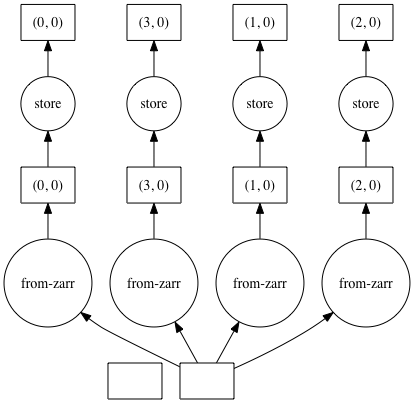

In [75]:
import zarr
import dask
import dask.array as dsa

store_source = {}
shape = (8, 8)
source_chunks = (1, 8)
read_chunks = (2, 8)
dtype = 'f4'

a_source = zarr.ones(shape, chunks=source_chunks,
                     dtype=dtype, store=store_source)
a_source.attrs['foo'] = 'bar'
d_source = dsa.from_zarr(a_source, chunks=read_chunks)

target_store = {}
a_target = zarr.empty(shape, chunks=source_chunks, dtype=dtype, store=target_store)
a_target.attrs.update(a_source.attrs)
store_future = dsa.store(d_source, a_target, lock=False, compute=False)


dask.visualize(store_future)


In [77]:
from dask.optimization import fuse
dsk_fused, deps = fuse(dask.utils.ensure_dict(store_future.dask))
delayed_fused = Delayed(store_future._key, dsk_fused)
delayed_fused.compute()

[None, None, None, None]

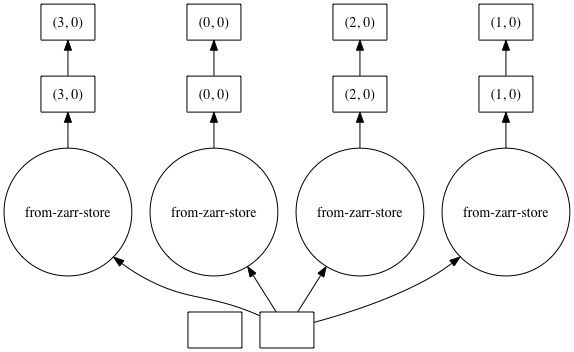

In [79]:
delayed_fused.visualize()

In [78]:
a_target[:]

array([[1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)

In [29]:
store_source = {}

shape = (8, 8)
source_chunks = (1, 8)
read_chunks = (2, 8)
dtype = 'f4'

a_source = zarr.ones(shape, chunks=source_chunks,
                     dtype=dtype, store=store_source)
a_source.attrs['foo'] = 'bar'
d_source = dsa.from_zarr(a_source, chunks=read_chunks)

target_store = {}
target_chunks = (2, 1)

a_target = zarr.empty(shape, chunks=target_chunks, dtype=dtype, store=target_store)
a_target.attrs.update(a_source.attrs)
store_future = dsa.store(d_source, a_target, lock=False, compute=False)


dask.visualize(store_future)


Delayed('store-0bb04ea0-98bc-11ea-a279-dca9046f1d7d')

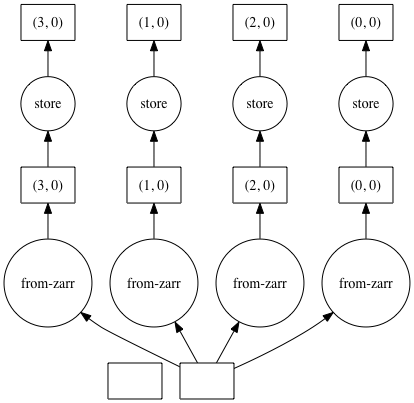

In [31]:
dask.visualize(store_future)

In [48]:
store_future_optimized = dask.optimize(store_future, optimizations=[fuse])[0]
store_future_optimized.visualize()

AttributeError: 'HighLevelGraph' object has no attribute 'copy'

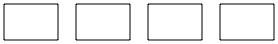

In [70]:
from dask.optimization import fuse

dsk = store_future.dask.dicts
dependencies = store_future.dask.dependencies
dsk_fused = fuse(store_future.dask.dicts)
dask.visualize(dsk_fused)

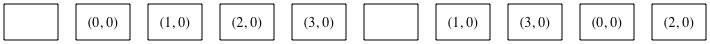

In [71]:
dsk_fused = fuse(dask.utils.ensure_dict(store_future.dask))
dask.visualize(dsk_fused)

In [74]:
from dask.delayed import Delayed
delayed_fused = Delayed("read-and-store", dsk_fused)
delayed_fused.compute()

ValueError: dictionary update sequence element #0 has length 10; 2 is required

In [73]:
delayed_fused)

ValueError: dictionary update sequence element #0 has length 10; 2 is required

In [66]:
dask.compute(store_future)

([None, None, None, None],)

In [67]:
a_target[:]

array([[1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)

In [14]:
store_future.dask.dependencies

{4604033152: set(), 4603945216: set(), 4603924288: set(), 4604099520: set()}

In [36]:
a_target.attrs

In [21]:
dsa.store?

Signature:
dsa.store(
    sources,
    targets,
    lock=True,
    regions=None,
    compute=True,
    return_stored=False,
    **kwargs,
)
Docstring:
Store dask arrays in array-like objects, overwrite data in target

This stores dask arrays into object that supports numpy-style setitem
indexing.  It stores values chunk by chunk so that it does not have to
fill up memory.  For best performance you can align the block size of
the storage target with the block size of your array.

If your data fits in memory then you may prefer calling
``np.array(myarray)`` instead.

Parameters
----------

sources: Array or iterable of Arrays
targets: array-like or Delayed or iterable of array-likes and/or Delayeds
    These should support setitem syntax ``target[10:20] = ...``
lock: boolean or threading.Lock, optional
    Whether or not to lock the data stores while storing.
    Pass True (lock each file individually), False (don't lock) or a
    particular ``threading.Lock`` object to be shared among a